In [ ]:
#install libraries

!rm -r kdg
!git clone -b weighted_kdn https://github.com/NeuroDataDesign/kdg
!ls
!pip install kdg/.

In [1]:
# import modules
import numpy as np
from tensorflow import keras
from keras import layers
import pandas as pd
import os

from kdg.kdn import *
from kdg.utils import gaussian_sparse_parity, trunk_sim

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive 
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/NDD/Weighted_KDN")
#os.mkdir("results_EFM")
#os.mkdir("plots")
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2021_10_21_high_dim_kdn_gaussian_weighting_FM.csv  kdg
2021_10_21_high_dim_kdn_gaussian_weighting_LL.csv  plots
2021_10_21_high_dim_kdn_gaussian_weighting_TM.csv  results_AP
high_dim_kdn_gaussian_weighting_allFC_TM.csv	   results_EFM


In [15]:
# define the experimental setup
p = 20 # total dimensions of the data vector
p_star = 3 # number of signal dimensions of the data vector
'''sample_size = np.logspace(
        np.log10(10),
        np.log10(50000),
        num=10,
        endpoint=True,
        dtype=int
        )'''

sample_size = [1000, 2000, 5000, 10000, 20000, 30000, 50000] # sample size under consideration
#network_size = [5, 10, 15, 20] #test under a variety of network sizes

#sample_size = [1000, 5000]

n_test = 1000 # test set size
reps = 10 # number of replicates

# NN params
compile_kwargs = {
    "loss": "binary_crossentropy",
    "optimizer": keras.optimizers.Adam(3e-4)
    }
fit_kwargs = {
    "epochs": 150,
    "batch_size": 32,
    "verbose": False
    }

#%%

# network architecture
def getNN(dense_size=5):
    network_base = keras.Sequential()
    network_base.add(layers.Dense(dense_size, activation='relu', input_shape=(20,)))
    network_base.add(layers.Dense(dense_size, activation='relu'))
    network_base.add(layers.Dense(units=2, activation = 'softmax'))
    network_base.compile(**compile_kwargs)
    return network_base
# %%

In [16]:
df = pd.DataFrame()
reps_list = []
sample_list = []
accuracy_kdn = []
accuracy_nn = []
accuracy_efm = []
accuracy_efm_backwards = []

for sample in sample_size:
    print('Doing sample %d'%sample)
    for ii in range(reps):
        X, y = gaussian_sparse_parity(
            sample,
            p_star=p_star,
            p=p
        )
        X_test, y_test = gaussian_sparse_parity(
            n_test,
            p_star=p_star,
            p=p
        )

        # train Vanilla NN
        vanilla_nn = getNN()
        vanilla_nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

        # train KDN - unweighted
        unweighted_kdn = kdn(network=vanilla_nn, weighting_method=None,verbose=False)
        unweighted_kdn.fit(X, y)

        accuracy_kdn.append(
            np.mean(
                unweighted_kdn.predict(X_test) == y_test
            )
        )

        # train KDN - pseudo-ensembled FM
        efm_kdn = kdn(network=vanilla_nn, weighting_method="EFM2", verbose=False)
        efm_kdn.fit(X, y)

        accuracy_efm.append(
            np.mean(
                efm_kdn.predict(X_test) == y_test
            )
        )
        
        # train KDN - pseudo-ensembled FM
        #moon_kdn = kdn(network=vanilla_nn, weighting_method="MOONWALK2", verbose=False)
        #moon_kdn.fit(X, y)

        #accuracy_efm_backwards.append(
        #    np.mean(
        #        moon_kdn.predict(X_test) == y_test
        #    )
        #)

        accuracy_nn.append(
            np.mean(
                np.argmax(vanilla_nn.predict(X_test), axis=1) == y_test
            )
        )
        reps_list.append(ii)
        sample_list.append(sample)
    print("NN Accuracy:", accuracy_nn[-reps:])
    print("KDN-Unweighted Accuracy:", accuracy_kdn[-reps:])
    print("KDN-EFM Accuracy Forward:", accuracy_efm[-reps:])
    #print("KDN-EFM Accuracy Backward:", accuracy_efm_backwards)

df['accuracy unweighted'] = accuracy_kdn
df['accuracy forward'] = accuracy_efm
#df['accuracy backward'] = accuracy_efm_backwards
df['accuracy nn'] = accuracy_nn
df['reps'] = reps_list
df['sample'] = sample_list

# save the results (CHANGE HERE)
df.to_csv('results_EFM/high_dim_kdn_gaussian_weighting_allFC_EFM_FlatY_samplesize.csv')

Doing sample 1000
NN Accuracy: [0.504, 0.54, 0.492, 0.587, 0.495, 0.504, 0.491, 0.533, 0.492, 0.507]
KDN-Unweighted Accuracy: [0.516, 0.497, 0.537, 0.609, 0.557, 0.576, 0.562, 0.521, 0.556, 0.551]
KDN-EFM Accuracy Forward: [0.524, 0.524, 0.481, 0.585, 0.496, 0.554, 0.513, 0.53, 0.518, 0.529]
Doing sample 2000
NN Accuracy: [0.724, 0.493, 0.698, 0.682, 0.502, 0.502, 0.499, 0.646, 0.516, 0.536]
KDN-Unweighted Accuracy: [0.694, 0.556, 0.638, 0.722, 0.582, 0.57, 0.547, 0.644, 0.57, 0.607]
KDN-EFM Accuracy Forward: [0.673, 0.536, 0.634, 0.677, 0.579, 0.516, 0.557, 0.693, 0.544, 0.565]
Doing sample 5000
NN Accuracy: [0.871, 0.884, 0.728, 0.865, 0.67, 0.867, 0.871, 0.829, 0.904, 0.891]
KDN-Unweighted Accuracy: [0.735, 0.729, 0.751, 0.704, 0.676, 0.736, 0.74, 0.731, 0.742, 0.773]
KDN-EFM Accuracy Forward: [0.844, 0.859, 0.842, 0.808, 0.762, 0.837, 0.787, 0.827, 0.855, 0.85]
Doing sample 10000
NN Accuracy: [0.872, 0.883, 0.793, 0.886, 0.847, 0.906, 0.796, 0.912, 0.849, 0.903]
KDN-Unweighted Accu

In [17]:
# %%

sample = 2000

df2 = pd.DataFrame()
reps_list = []
accuracy_kdn = []
accuracy_nn = []
accuracy_efm = []
sample_list = []

for N in network_size:
    print(f'Using network with {N} nodes')
    for ii in range(reps):
        X, y = gaussian_sparse_parity(
            sample,
            p_star=p_star,
            p=p
        )
        X_test, y_test = gaussian_sparse_parity(
            n_test,
            p_star=p_star,
            p=p
        )

        # train Vanilla NN
        vanilla_nn = getNN(N)
        vanilla_nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

        # train KDN - unweighted
        unweighted_kdn = kdn(network=vanilla_nn, weighting_method=None,verbose=False)
        unweighted_kdn.fit(X, y)

        accuracy_kdn.append(
            np.mean(
                unweighted_kdn.predict(X_test) == y_test
            )
        )

        # train KDN - pseudo-ensembled FM
        efm_kdn = kdn(network=vanilla_nn, weighting_method="EFM", verbose=False)
        efm_kdn.fit(X, y)

        accuracy_efm.append(
            np.mean(
                efm_kdn.predict(X_test) == y_test
            )
        )
        
        accuracy_nn.append(
            np.mean(
                np.argmax(vanilla_nn.predict(X_test), axis=1) == y_test
            )
        )
        reps_list.append(ii)
        sample_list.append(N)
    print("NN Accuracy:", accuracy_nn)
    print("KDN-Unweighted Accuracy:", accuracy_kdn)
    print("KDN-EFM Accuracy:", accuracy_efm)
    
df2['accuracy unweighted'] = accuracy_kdn
df2['accuracy efm'] = accuracy_efm
df2['accuracy nn'] = accuracy_nn
df2['reps'] = reps_list
df2['sample'] = sample_list

# save the results (CHANGE HERE)
df2.to_csv('results_EFM/high_dim_kdn_gaussian_weighting_allFC_EFM_networksize.csv')

NameError: ignored

1000
2000
5000
10000
20000
30000
50000


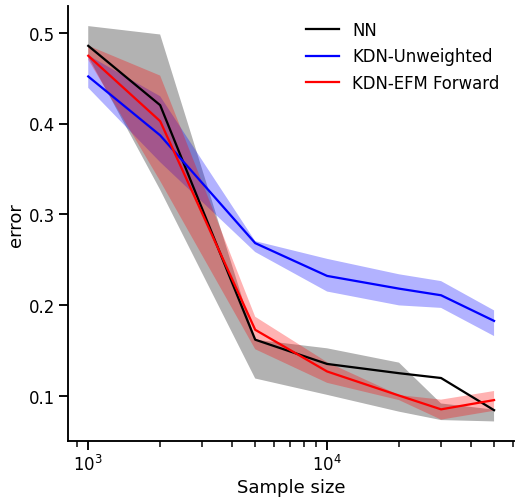

In [23]:
# %% plot the result
import pandas as pd
# Specify which results to plot (CHANGE HERE)
filename1 = 'results_EFM/high_dim_kdn_gaussian_weighting_allFC_EFM_FlatY_samplesize.csv'

df = pd.read_csv(filename1)

err_nn_med = []
err_nn_25_quantile = []
err_nn_75_quantile = []

err_kdn_med = []
err_kdn_25_quantile = []
err_kdn_75_quantile = []

err_efm_med = []
err_efm_25_quantile = []
err_efm_75_quantile = []

err_efm_back_med = []
err_efm_back_25_quantile = []
err_efm_back_75_quantile = []

#clr = ["#e41a1c", "#f781bf", "#306998"]
#c = sns.color_palette(clr, n_colors=3)

for sample in sample_size:
    print(sample)
    err_nn = 1 - df['accuracy nn'][df['sample']==sample]
    #err_rf_ = 1 - df['feature selected rf'][df['sample']==sample]
    err_kdn = 1 - df['accuracy unweighted'][df['sample']==sample]
    #err_kdf_ = 1 - df['feature selected kdf'][df['sample']==sample]
    err_efm = 1 - df['accuracy forward'][df['sample']==sample]
    #err_efm_back = 1 - df['accuracy backward'][df['sample']==sample]

    err_nn_med.append(np.mean(err_nn))
    err_nn_25_quantile.append(
            np.quantile(err_nn,[.25])[0]
        )
    err_nn_75_quantile.append(
        np.quantile(err_nn,[.75])[0]
    )

    #err_rf_med_.append(np.mean(err_rf_))
    #err_rf_25_quantile_.append(
    #        np.quantile(err_rf_,[.25])[0]
    #    )
    #err_rf_75_quantile_.append(
    #    np.quantile(err_rf_,[.75])[0]
    #)

    err_kdn_med.append(np.mean(err_kdn))
    err_kdn_25_quantile.append(
            np.quantile(err_kdn,[.25])[0]
        )
    err_kdn_75_quantile.append(
        np.quantile(err_kdn,[.75])[0]
    )

    err_efm_med.append(np.mean(err_efm))
    err_efm_25_quantile.append(
            np.quantile(err_efm,[.25])[0]
        )
    err_efm_75_quantile.append(
        np.quantile(err_efm,[.75])[0]
    )

    '''err_efm_back_med.append(np.mean(err_efm_back))
    err_efm_back_25_quantile.append(
            np.quantile(err_efm_back,[.25])[0]
        )
    err_efm_back_75_quantile.append(
        np.quantile(err_efm_back,[.75])[0]
    )'''

    #err_kdf_med_.append(np.mean(err_kdf_))
    #err_kdf_25_quantile_.append(
    #        np.quantile(err_kdf_,[.25])[0]
    #    )
    #err_kdf_75_quantile_.append(
    #    np.quantile(err_kdf_,[.75])[0]
    #)

sns.set_context('talk')
fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.plot(sample_size, err_nn_med, c="k", label='NN')
ax.fill_between(sample_size, err_nn_25_quantile, err_nn_75_quantile, facecolor='k', alpha=.3)

ax.plot(sample_size, err_kdn_med, c="b", label='KDN-Unweighted')
ax.fill_between(sample_size, err_kdn_25_quantile, err_kdn_75_quantile, facecolor='b', alpha=.3)

ax.plot(sample_size, err_efm_med, c="r", label='KDN-EFM Forward')
ax.fill_between(sample_size, err_efm_25_quantile, err_efm_75_quantile, facecolor='r', alpha=.3)

#ax.plot(sample_size, err_efm_back_med, c="g", label='KDN-EFM Backward')
#ax.fill_between(sample_size, err_efm_back_25_quantile, err_efm_back_75_quantile, facecolor='g', alpha=.3)


right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

ax.set_xscale('log')
ax.set_xlabel('Sample size')
ax.set_ylabel('error')
ax.legend(frameon=False)

# Specify the save path (CHANGE HERE)
plt.savefig('plots/high_dim_efm_gaussian_weighting_allFC_EFMMOON_samplesize.pdf')